# Lab6

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

Option A: do the calculation with sql

In [3]:
q1_sql = """
SELECT
    year,
    pop,
    ROUND(
        100.0 * (pop - LAG(pop) OVER (ORDER BY year)) / LAG(pop) OVER (ORDER BY year),
        2
    ) AS growth_rate_percent
FROM
    population p
JOIN
    name n ON p.fips = n.fips
WHERE
    n.name = 'California'
ORDER BY
    year;
    """

In [4]:
sql = """
     select * from name_income
     where fips = '06'
     """

In [5]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_8990/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,pop,growth_rate_percent
0,2005,35278768,NaN
1,2006,36457549,3.34
2,2007,36553215,0.26
3,2008,36756666,0.56
4,2009,36961664,0.56


In [6]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [7]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.1 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [10]:
%load_ext jupyter_ai_magics

In [11]:
%%ai gpt4 -f code
What is included in the {q1_df} creates a line chart with the growth rate.
Chart must include the CA name in title

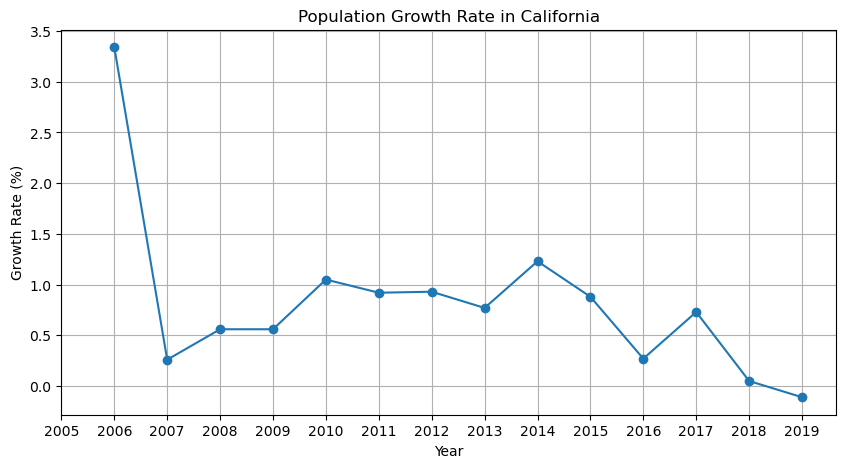

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Recreate the proper DataFrame
df = pd.DataFrame({
    'year': [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    'growth_rate_percent': [None,3.34,0.26,0.56,0.56,1.05,0.92,0.93,0.77,1.23,0.88,0.27,0.73,0.05,-0.11]
})

# Make sure the year column is numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')

plt.figure(figsize=(10,5))
plt.plot(df['year'], df['growth_rate_percent'], marker='o')
plt.title('Population Growth Rate in California')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks(df['year'])   # force the correct x-axis labels
plt.grid(True)
plt.show()


Explanation: This chart shows the growth rate percentage in California from 2005-2019. As seen there is a sharp decrease from 2006 to 2007, then a steady increase to 2010. From there we see mostly a steady decrease to 2013, and then multiple up and down spikes with peaks being at 2014 ande 2017.

## Q2 - Income and Population Relationship

In [14]:
q2_sql = """
SELECT 
    p.year,
    p.pop AS population,
    i.income
FROM income i
JOIN population p 
    ON p.fips = i.fips 
   AND p.year = i.year
WHERE p.fips = '06'
ORDER BY p.year ASC;
"""

In [15]:

q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

/tmp/ipykernel_8990/3723254887.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,year,population,income
0,2005,35278768,53629
1,2006,36457549,56645
2,2007,36553215,59948
3,2008,36756666,61021
4,2009,36961664,58931


In [16]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [20]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


In [21]:
%%ai gpt4 -f code
use the data in datframe {q2_df},visualization: create a dual-axis chart in python with Jupyter AI's help:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name in the title.

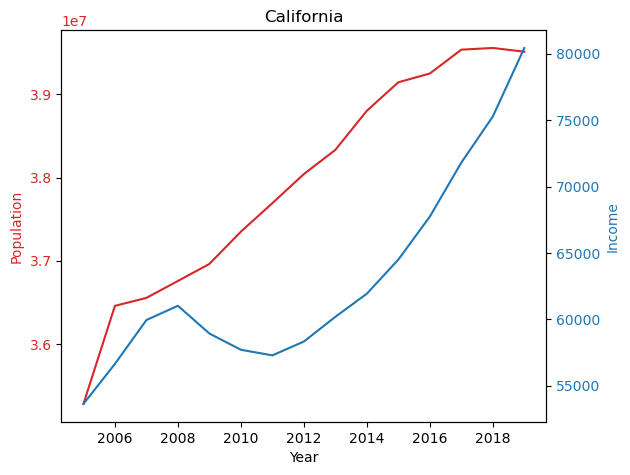

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df = {'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      'population': [35278768, 36457549, 36553215, 36756666, 36961664, 37349363, 37691912, 38041430, 38332521, 38802500, 
                     39144818, 39250017, 39536653, 39557045, 39512223],
      'income': [53629, 56645, 59948, 61021, 58931, 57708, 57287, 58328, 60190, 61933, 64500, 67739, 71805, 75277, 80440]}

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df['year'], df['population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Income', color=color)  
ax2.plot(df['year'], df['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title("California")
plt.show()

This chart shows the relation of population and income in California from the years 2005-2019. As seen population sees increase for almost the entire time period, while income sees a decrease from 2008-2011 with an increase every other year. 

## Q3 - Student Defined Question

Question: Relationship between population size and growth rate.

In [23]:
q3_sql = """
SELECT 
    p1.fips,
    n.name AS state_name,
    p1.year,
    p1.pop,
    ROUND(
        (
            (p1.pop - LAG(p1.pop) OVER (PARTITION BY p1.fips ORDER BY p1.year)) 
            / LAG(p1.pop::numeric) OVER (PARTITION BY p1.fips ORDER BY p1.year)
            * 100
        ), 4
    ) AS growth_rate_percent
FROM population p1
JOIN name n 
    ON p1.fips = n.fips
WHERE p1.fips = '06'
"""

In [24]:
q3_df = pd.read_sql(q3_sql, con=conn)
q3_df.head() #show the top 5 rows

/tmp/ipykernel_8990/1556252375.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,fips,state_name,year,pop,growth_rate_percent
0,06,California,2005,35278768,NaN
1,06,California,2006,36457549,3.3413
2,06,California,2007,36553215,0.2624
3,06,California,2008,36756666,0.5566
4,06,California,2009,36961664,0.5577


In [25]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [29]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


In [31]:
%%ai gpt4 -f code
# Using the data in DataFrame {q1_df}, visualize the year-over-year population growth rate.
# Requirements:
# • X-axis = year
# • Left Y-axis = population (line, blue)
# • Right Y-axis = growth_rate_percent (line, orange)
# • Chart must include the state name in the title.

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# Left Y-axis: population
ax1.plot(q1_df["year"], q1_df["pop"], color="tab:blue", marker="o", label="Population")
ax1.set_xlabel("Year")
ax1.set_ylabel("Population", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right Y-axis: growth rate (%)
ax2 = ax1.twinx()
ax2.plot(q1_df["year"], q1_df["growth_rate_percent"], color="tab:orange", marker="s", label="Growth Rate (%)")
ax2.set_ylabel("Population Growth Rate (%)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Title includes the state name
state_name = q1_df["state_name"].iloc[0] if "state_name" in q1_df.columns else "California"
plt.title(f"Year-over-Year Population Growth – {state_name}")

# Add grid and improve layout
ax1.grid(True, linestyle="--", alpha=0.6)
fig.tight_layout()
plt.show()


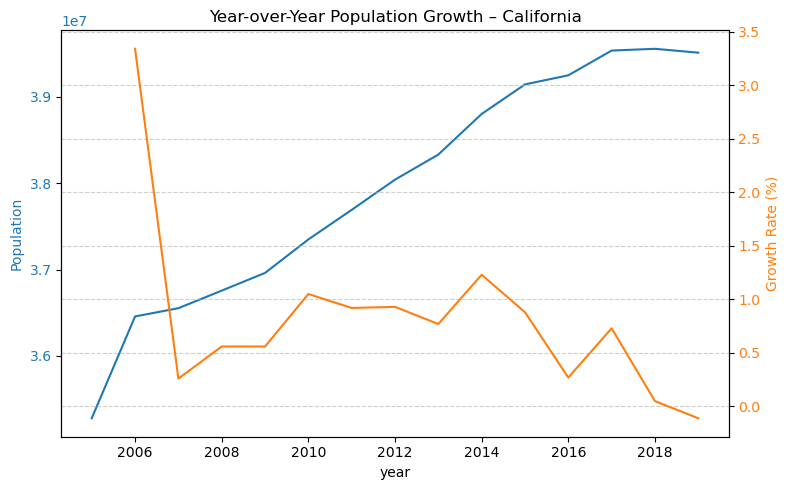

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'pop': [35278768, 36457549, 36553215, 36756666, 36961664, 37349363, 37691912, 38041430, 38332521, 38802500, 39144818, 39250017, 39536653, 39557045, 39512223],
    'growth_rate_percent': [None, 3.34, 0.26, 0.56, 0.56, 1.05, 0.92, 0.93, 0.77, 1.23, 0.88, 0.27, 0.73, 0.05, -0.11]
})

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("year")
ax1.set_ylabel("Population", color="tab:blue")
ax1.plot(df["year"], df["pop"], color='tab:blue')
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Growth Rate (%)", color="tab:orange")
ax2.plot(df["year"], df["growth_rate_percent"], color='tab:orange')
ax2.tick_params(axis='y', labelcolor="tab:orange")

plt.title("Year-over-Year Population Growth – California")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

This graph shows population and growth rate in California from 2005-2019. It is the same charts from questions one and two, however they are compared to eachother in this one to show relation. The growth rate sharply decreases from 2006 to 2007, then it sees a steady increase until 2010. It then steadily decreases for the most part to 2013 with a slight in 2011. It then end with two peaks in 2014 and 2017 and ends with a decrease. There does not seem to be a relationship between growth rate and population as population grows almost every year, and growth rate has frequent up and downs.